In [1]:
import pandas as pd
import numpy as np
from recmetrics.plots import LongTailPlot, CoveragePlot, MarkPlot
from recmetrics.metrics import mark, coverage, personalization, intra_list_similarity
import matplotlib.pyplot as plt

# MovieLense Dataset
Using the MovieLens 20M Dataset dataset for examples. You can download this data here: https://grouplens.org/datasets/movielens/20m/

In [2]:
ratings = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/ratings.csv')
ratings = ratings.query('rating >=3')
ratings.reset_index(drop=True, inplace=True)

In [3]:
#only consider ratings from users who have rated over n movies
n=500
users = ratings.userId.value_counts()
users = users[users>n].index.tolist()

In [4]:
ratings = ratings.query('userId in @users')
print ratings.shape
ratings.head(3)

(4020277, 4)


,userId,movieId,rating,timestamp
4712,54,1,4.0,974840421
4713,54,2,3.0,974918176
4714,54,5,3.0,974841378


In [5]:
# get movie features

rated_movies = ratings.movieId.tolist()
movies = pd.read_csv('../movie_similarity_flask_api/data/ml-20m/movies.csv')
movies = movies.query('movieId in @rated_movies')
movies.set_index("movieId", inplace=True, drop=True)

movies = movies.genres.str.split("|", expand=True)
movies.reset_index(inplace=True)
movies = pd.melt(movies, id_vars='movieId', value_vars=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
movies.set_index('movieId', inplace=True)

movies = pd.get_dummies(movies.value)
#movies = movies[['Action', 'Romance', 'Western', 'Comedy', 'Crime']]
movies.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Long Tail Plot Example

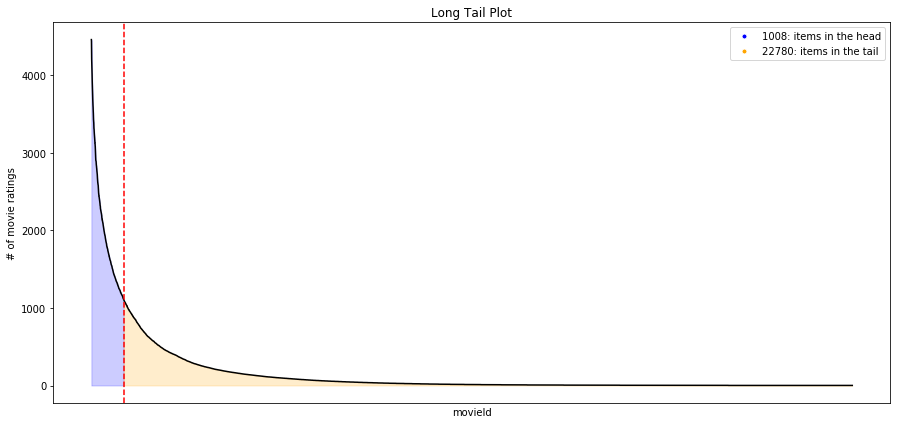

In [6]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 7))
    
LongTailPlot(df=ratings, 
             item_id_column="movieId", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

## test/train split

In [7]:
# the test data contains 100 movies from each user that are rated greater than 3 stars
test_index = ratings.copy()
test_index = test_index.groupby('userId')
test_index = test_index.apply(lambda x: x.sample(min(100, len(x))))

test_index.drop(axis=1, columns="userId", inplace=True)
test_index.reset_index(inplace=True, drop=False)
test_index = test_index.level_1.values.tolist()

test_df = ratings.loc[test_index]
test = test_df.copy().groupby('userId')['movieId'].agg({'actual': (lambda x: list(set(x)))})
test.head()

/Users/clairelongo/Documents/Work/prof_dev/recmetrics/venv/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()


,actual
userId,
54,"[1028, 2421, 1036, 2071, 3608, 3098, 1370, 32,..."
58,"[3072, 527, 1552, 4633, 4128, 1573, 553, 1586,..."
91,"[3, 8207, 42002, 4642, 5679, 4874, 62, 1090, 2..."
104,"[2565, 1545, 2065, 529, 3095, 3096, 2078, 1057..."
156,"[5120, 4, 4177, 9, 10, 1551, 20, 1558, 3247, 5..."


In [8]:
train_long = ratings[~ratings.index.isin(test_index)].dropna()
train_long.head()

,userId,movieId,rating,timestamp
4712,54,1,4.0,974840421
4713,54,2,3.0,974918176
4714,54,5,3.0,974841378
4715,54,6,3.0,974836300
4716,54,10,4.0,974838872


# Popularity Recommender
Creating a simple popularity recommender to demonstrate recommender metrics in action. The popularity recommender simply recommends the top 10 movies to every user.

In [9]:
#make recommendations for all members in the test data
popularity_recs = train_long.movieId.value_counts().head(10).index.tolist()

recs = []
for user in test.index.tolist():
    pop_predictions = popularity_recs
    recs.append(pop_predictions)
        
test['pop_predictions'] = recs
test.head()

,actual,pop_predictions
userId,,
54,"[1028, 2421, 1036, 2071, 3608, 3098, 1370, 32,...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ..."
58,"[3072, 527, 1552, 4633, 4128, 1573, 553, 1586,...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ..."
91,"[3, 8207, 42002, 4642, 5679, 4874, 62, 1090, 2...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ..."
104,"[2565, 1545, 2065, 529, 3095, 3096, 2078, 1057...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ..."
156,"[5120, 4, 4177, 9, 10, 1551, 20, 1558, 3247, 5...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ..."


In [10]:
actual = test.actual.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()

# Random Recommender
Creating a simple random recommender to demonstrate recommender metrics in action. The random recommender simply recommends 10 random movies to every user.

In [11]:
#make recommendations for all members in the test data

recs = []
for user in test.index.tolist():
    random_predictions = train_long.movieId.sample(10).values.tolist()
    recs.append(random_predictions)
        
test['random_predictions'] = recs
test.head()

,actual,pop_predictions,random_predictions
userId,,,
54,"[1028, 2421, 1036, 2071, 3608, 3098, 1370, 32,...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[3330, 1466, 68848, 82459, 8042, 4126, 2859, 8..."
58,"[3072, 527, 1552, 4633, 4128, 1573, 553, 1586,...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[4553, 1394, 1207, 783, 4370, 47629, 965, 1187..."
91,"[3, 8207, 42002, 4642, 5679, 4874, 62, 1090, 2...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[6708, 68952, 1203, 87520, 2901, 230, 4356, 65..."
104,"[2565, 1545, 2065, 529, 3095, 3096, 2078, 1057...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[106782, 2761, 858, 454, 1340, 6777, 4036, 366..."
156,"[5120, 4, 4177, 9, 10, 1551, 20, 1558, 3247, 5...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[2463, 5673, 2668, 5159, 4815, 2393, 2324, 339..."


In [12]:
random_predictions = test.random_predictions.values.tolist()

# Collaborative Filter Recommender
Creating a simple CF to demonstrate recommender metrics in action. The collaborative filter transforms user-item interactions into latent space, and reconstructs the user-item matrix to impute ratings missing movie ratings. The predicted rating is the dot product between the user and movie vectors in latent space. 

In [13]:
train_pivot = train_long.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
user_index = train_pivot.index.tolist()
movie_index = train_pivot.columns.tolist()
train_pivot.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,...,131231,131239,131241,131243,131248,131250,131252,131256,131260,131262
userId,,,,,,,,,,,,,,,,,,,,,
54,4.0,3.0,0.0,0.0,3.0,3.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58,5.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
91,4.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

#svd
U, sigma, Vt = svds(train_pivot, k=100) # k is the number of factors
eigvals = sigma**2 / np.cumsum(sigma)[-1]
eigvals = eigvals[::-1]
sigma = np.diag(sigma)

#reconstruct ratings matrix
cf_model = np.dot(np.dot(U, sigma), Vt) 
cf_model = pd.DataFrame(cf_model, index=user_index, columns=movie_index)

In [15]:
cf_model.head()

,1,2,3,4,5,6,7,8,9,10,...,131231,131239,131241,131243,131248,131250,131252,131256,131260,131262
54,3.025654,1.629073,0.771659,0.172919,0.706093,2.367049,0.902096,-0.057009,0.429211,3.302369,...,0.009627,-0.001587,-0.001587,-0.001587,-0.001587,-0.001587,-0.001587,-0.001587,-0.002046,-0.004866
58,2.169980,1.217712,0.627969,0.012603,0.794271,3.286245,1.296575,0.051459,0.136213,0.725836,...,0.002183,-0.008112,-0.008112,-0.008112,-0.008112,-0.008112,-0.008112,-0.008112,0.004166,0.007814
91,3.807711,2.044627,0.616534,-0.167206,0.710457,1.337780,0.765050,-0.020600,-0.166754,2.244710,...,-0.010064,-0.005345,-0.005345,-0.005345,-0.005345,-0.005345,-0.005345,-0.005345,-0.005811,0.001397
104,1.973279,-0.092845,-0.429794,0.106620,0.009175,0.757379,0.129609,0.129284,-0.130128,-0.371718,...,-0.003730,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002907,-0.002154,0.003203
156,3.141683,4.439334,1.766549,1.515007,1.369070,3.040229,3.099292,1.115031,1.382735,4.231738,...,-0.004619,0.005176,0.005176,0.005176,0.005176,0.005176,0.005176,0.005176,0.005904,-0.004642


In [16]:
def get_users_predictions(user_id, n, model, train_long):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    rated_items_from_train = train_long.query('userId == @user_id').movieId.tolist()
    recommended_items = recommended_items[~recommended_items.index.isin(rated_items_from_train)]
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

In [17]:
get_users_predictions(156, 10, cf_model, train_long)

[593, 1200, 1711, 260, 1586, 3671, 4361, 10, 368, 1544]

In [18]:
#make recommendations for all members in the test data

recs = []
for user in user_index:
    cf_predictions = get_users_predictions(user, 10, cf_model, train_long)
    recs.append(cf_predictions)
        
test['cf_predictions'] = recs
test.head()

,actual,pop_predictions,random_predictions,cf_predictions
userId,,,,
54,"[1028, 2421, 1036, 2071, 3608, 3098, 1370, 32,...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[3330, 1466, 68848, 82459, 8042, 4126, 2859, 8...","[1198, 2716, 1291, 1376, 2000, 1721, 1674, 103..."
58,"[3072, 527, 1552, 4633, 4128, 1573, 553, 1586,...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[4553, 1394, 1207, 783, 4370, 47629, 965, 1187...","[904, 912, 1343, 1208, 527, 111, 1263, 4993, 2..."
91,"[3, 8207, 42002, 4642, 5679, 4874, 62, 1090, 2...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[6708, 68952, 1203, 87520, 2901, 230, 4356, 65...","[293, 1641, 4993, 110, 4308, 34, 588, 3578, 15..."
104,"[2565, 1545, 2065, 529, 3095, 3096, 2078, 1057...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[106782, 2761, 858, 454, 1340, 6777, 4036, 366...","[750, 1207, 1228, 1248, 905, 1041, 1103, 800, ..."
156,"[5120, 4, 4177, 9, 10, 1551, 20, 1558, 3247, 5...","[1270, 1198, 2571, 593, 318, 1196, 296, 2762, ...","[2463, 5673, 2668, 5159, 4815, 2393, 2324, 339...","[593, 1200, 1711, 260, 1586, 3671, 4361, 10, 3..."


In [19]:
cf_predictions = test.cf_predictions.values.tolist()

# Recall

In [20]:
pop_mark = []
for K in np.arange(1, 11):
    pop_mark.extend([mark(actual, pop_predictions, k=K)])
pop_mark

[0.001267123287671233,
 0.0019973811442385173,
 0.002518466290625839,
 0.0029772696749932846,
 0.0033338369594413104,
 0.00363534112275047,
 0.003946150377959402,
 0.004232210007290587,
 0.004514688295409488,
 0.004750385313942929]

In [21]:
random_mark = []
for K in np.arange(1, 11):
    random_mark.extend([mark(actual, random_predictions, k=K)])
random_mark

[0.00041498791297340853,
 0.0006013295729250605,
 0.0007336153639538007,
 0.0008343405855492882,
 0.0009205613752350255,
 0.0009927477840451248,
 0.001050592839875676,
 0.001106243524807183,
 0.001157501470907998,
 0.0012076626312625507]

In [22]:
cf_mark = []
for K in np.arange(1, 11):
    cf_mark.extend([mark(actual, cf_predictions, k=K)])
cf_mark

[0.008702659145850122,
 0.01653303787268332,
 0.02380472737040021,
 0.030702390545259205,
 0.03718385710448563,
 0.04318237980123556,
 0.049010053336403056,
 0.05441043609224511,
 0.05968776620237136,
 0.06469663002187177]

# Mark Plot

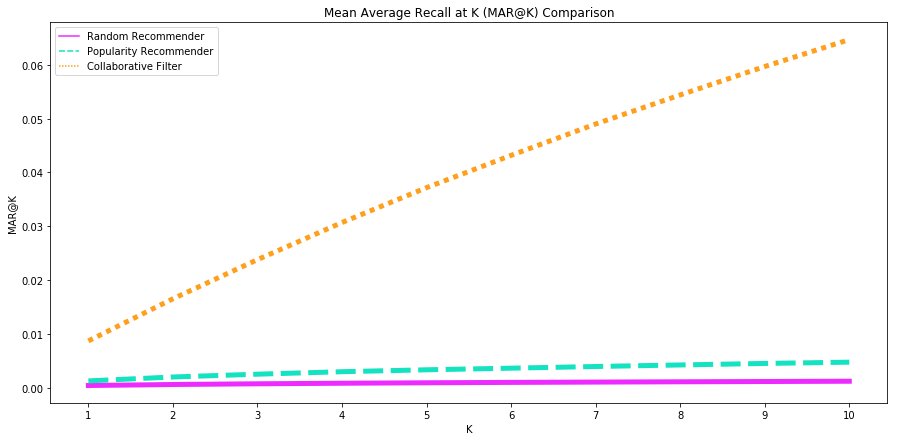

In [23]:
mark_scores = [random_mark, pop_mark, cf_mark]
index = range(1,10+1)
names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
MarkPlot(mark_scores, model_names=names, k_range=index)

# Coverage

In [24]:
catalog = train_long.movieId.unique().tolist()
random_coverage = coverage(random_predictions, catalog)
pop_coverage = coverage(pop_predictions, catalog)
cf_coverage = coverage(cf_predictions, catalog)

# Coverage Plot

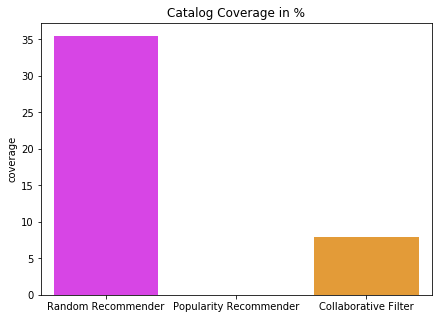

In [25]:
coverage_scores = [random_coverage, pop_coverage, cf_coverage]
model_names = ['Random Recommender', 'Popularity Recommender', 'Collaborative Filter']

fig = plt.figure(figsize=(7, 5))
CoveragePlot(coverage_scores, model_names)

# Personalization

In [26]:
example_predictions = [
    ['A', 'B', 'C', 'D'],
    ['A', 'B', 'C', 'Y']
]

In [27]:
personalization(predicted=example_predictions)

0.25

# Intra-list Similarity

In [28]:
movies[movies.sum(axis=1)>0].head(5)

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieId,,,,,,,,,,,,,,,,,,,,
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
intra_list_similarity(predicted=cf_predictions, feature_df=movies)

0.17709284627092844